# Acrescentando Redes Neurais à degustação

![](https://media.giphy.com/media/E3L5goMMSoAAo/giphy.gif)



## Lembrando as variáveis do nosso problema

Usaremos um dataset composto por propriedades físico-químicas de vinhos tintos. Temos 1599 amostras e um total de 11 variáveis independentes, descritas abaixo:

 - `fixed acidity`: a maioria dos ácidos envolvidos com vinho (não evaporam prontamente)
 - `volatile acidity`: a quantidade de ácido acético no vinho, que em níveis muito altos pode levar a um gosto desagradável de vinagre
 - `citric acid`: encontrado em pequenas quantidades, o ácido cítrico pode adicionar "leveza" e sabor aos vinhos
 - `residual sugar`: a quantidade de açúcar restante após a fermentação é interrompida, é raro encontrar vinhos com menos de 1 grama / litro e vinhos com mais de 45 gramas / litro são considerados doces
 - `chlorides`: a quantidade de sal no vinho
free sulfur dioxide: a forma livre de SO2 existe em equilíbrio entre o SO2 molecular (como gás dissolvido) e o íon bissulfito; impede o crescimento microbiano e a oxidação do vinho
 - `total sulfur dioxide`: Quantidade de formas livres e encadernadas de S02; em baixas concentrações, o SO2 é quase indetectável no vinho, mas nas concentrações de SO2 acima de 50 ppm, o SO2 se torna evidente no nariz e no sabor do vinho.
 - `density`: a densidade do vinho é próxima a da água, dependendo do percentual de álcool e teor de açúcar
 - `pH`: descreve se o vinho é ácido ou básico numa escala de 0 (muito ácido) a 14 (muito básico); a maioria dos vinhos está entre 3-4 na escala de pH
 - `sulphates`: um aditivo de vinho que pode contribuir para os níveis de gás de dióxido de enxofre (S02), que age como um antimicrobiano e antioxidante
 - `alcohol`: o percentual de álcool no vinho


Existe ainda uma variável chamada `quality`. Essa variável é uma nota de qualidade do vinho que varia de 0 a 10.

Criamos uma variável que determina se um vinho é considerado bom ou ruim, baseado na quality. Se quality > 5, o vinho é bom.

In [ ]:
# Import necessary packages
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import deepcopy as cp
from sklearn.preprocessing import StandardScaler

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Neural Network MLP
from sklearn.neural_network import MLPClassifier

# SVM
from sklearn.svm import SVC


# Decision Tree
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)

sns.set_style("ticks")
sns.set_context("paper")

random_state = 42

# Exploratory Data

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine = pd.read_csv(url, sep=";")
wine["category"] = (wine.quality > 5).astype(float)

vars = [
   'fixed acidity',
   'volatile acidity',
   'citric acid',
   'residual sugar',
   'chlorides',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'density',
   'pH',
   'sulphates',
   'alcohol'
]

X = wine[vars]
y = wine['category']

# Treinamento com validação cruzada

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [ ]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X.values,
                                                          y.values,
                                                          test_size=0.2, # 20 % da base
                                                          random_state=42,
                                                          stratify=y)


In [ ]:
def train(X, y, model_klass, n_splits=5, n_init=1, **kwargs):
    cv = StratifiedKFold(n_splits=n_splits)
    f1_score_val_list = []
    f1_score_train_list = []
    model_list =[]
    scaler_list = []
    # Validação cruzada só em Training Data
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]

        # Escala
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        scaler_list.append(scaler)
        # TO DO - Fazer a PCA como opcional
        # Treino
        model = None
        f1_score_val = 0.
        for idx in range(n_init):
            _model = model_klass(**kwargs)
            _model.fit(X_train_scaled, y_train)
            _y_pred = _model.predict(X_train_scaled)
            _y_pred_val = _model.predict(X_val_scaled)
            _f1_score_val = f1_score(y_val, _y_pred_val)
            if _f1_score_val > f1_score_val:
                y_pred_val = _y_pred_val
                y_pred = _y_pred
                model = _model
        print(f"========================= FOLD {fold} ==========================")
        print(f"Meu resultado para treino de F1-Score é {f1_score(y_train, y_pred):.2}")
        print(f"Meu resultado para validação de F1-Score é {f1_score(y_val, y_pred_val):.2}")
        f1_score_val_list.append(f1_score(y_val, y_pred_val))
        f1_score_train_list.append(f1_score(y_train, y_pred))
        model_list.append(model)
    print()
    print()
    mean_val = np.mean(f1_score_val_list)
    std_val = np.std(f1_score_val_list)
    print(f"Meu resultado de F1-Score Médio de treino é {np.mean(f1_score_train_list): .2} +- {np.std(f1_score_train_list): .2} ")
    print(f"Meu resultado de F1-Score Médio de validação é {mean_val: .2} +- {std_val: .2} ")
    print()

    best_model_idx = np.argmax(f1_score_val_list)
    print(f"Meu melhor fold é: {best_model_idx} ")
    best_model = model_list[best_model_idx]
    best_scaler = scaler_list[best_model_idx]
    return best_model, mean_val, std_val, best_scaler

# Model

## Logistic Regression

In [ ]:
logit_model, logit_mean_val, logit_std_val, logit_scaler = train(X_train_cv, y_train_cv, LogisticRegression)

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.75
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.77
Meu resultado para validação de F1-Score é 0.72
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.75
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  0.76 +-  0.007 
Meu resultado de F1-Score Médio de validação é  0.76 +-  0.024 

Meu melhor fold é: 4 


## Decision Tree

In [ ]:
tree_model, tree_mean_val, tree_std_val, tree_scaler  = train(X_train_cv, y_train_cv, DecisionTreeClassifier)

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.74
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.73
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.77
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  1.0 +-  0.0 
Meu resultado de F1-Score Médio de validação é  0.76 +-  0.023 

Meu melhor fold é: 4 


In [ ]:
tree_50_leaf_model, tree_50_leaf_mean_val, tree_50_leaf_std_val, tree_50_leaf_scaler  = train(X_train_cv,
                                                                                              y_train_cv,
                                                                                              DecisionTreeClassifier,
                                                                                              min_samples_leaf=50)

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.78
Meu resultado para validação de F1-Score é 0.71
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.77
Meu resultado para validação de F1-Score é 0.73
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.79
Meu resultado para validação de F1-Score é 0.74
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.77
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.79
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  0.78 +-  0.0075 
Meu resultado de F1-Score Médio de validação é  0.75 +-  0.027 

Meu melhor fold é: 4 


## SVM

In [ ]:
svm_rbf_model, svm_rbf_mean_val, svm_rbf_std_val, svm_rbf_scaler = train(X_train_cv,
                                                                         y_train_cv,
                                                                         SVC,
                                                                         gamma = 'auto',
                                                                         C= 1,
                                                                         kernel= 'rbf')

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.78
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.77
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.77
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  0.81 +-  0.0033 
Meu resultado de F1-Score Médio de validação é  0.77 +-  0.011 

Meu melhor fold é: 4 


In [ ]:
svm_poly_3_model, svm_poly_3_mean_val, svm_poly_3_std_val, svm_poly_3_scaler = train(X_train_cv,
                                                                                     y_train_cv,
                                                                                     SVC,
                                                                                     gamma= 'auto',
                                                                                     C=1,
                                                                                     degree=3,
                                                                                     kernel= 'poly')

svm_poly_5_model, svm_poly_5_mean_val, svm_poly_5_std_val, svm_poly_5_scaler = train(X_train_cv,
                                                                                     y_train_cv,
                                                                                     SVC,
                                                                                     gamma= 'auto',
                                                                                     C=1,
                                                                                     degree=5,
                                                                                     kernel= 'poly')

svm_poly_10_model, svm_poly_10_mean_val, svm_poly_10_std_val, svm_poly_10_scaler = train(X_train_cv,
                                                                                         y_train_cv,
                                                                                         SVC,
                                                                                         gamma= 'auto',
                                                                                         C=1,
                                                                                         degree=10,
                                                                                         kernel= 'poly')

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.75
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.82
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.8
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.81
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  0.81 +-  0.0046 
Meu resultado de F1-Score Médio de validação é  0.76 +-  0.013 

Meu melhor fold é: 4 
========================= FOLD 0 ==========================
Meu resultado para treino

# Neural Network

In [ ]:
nn_results =[]
for neurons in range(1, 30):
    nn_model, nn_mean_val, nn_std_val, nn_scaler = train(X_train_cv, y_train_cv,
                                                         MLPClassifier,
                                                         hidden_layer_sizes=(neurons,),
                                                         n_init=10,
                                                         max_iter=10000,
                                                         activation="logistic",
                                                         alpha=1e-5,
                                                         tol=1e-3,
                                                         learning_rate_init=.3,
                                                         solver='sgd')

    nn_results.append((f"Neural Network ({neurons} neurons)", nn_mean_val, nn_std_val))


========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.73
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.78
Meu resultado para validação de F1-Score é 0.74
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.75
Meu resultado para validação de F1-Score é 0.74
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.75
Meu resultado para validação de F1-Score é 0.78


Meu resultado de F1-Score Médio de treino é  0.76 +-  0.012 
Meu resultado de F1-Score Médio de validação é  0.75 +-  0.019 

Meu melhor fold é: 4 
========================= FOLD 0 ==========================
Meu resultado para treino

# Overall Results

In [ ]:
results = [
    ('Logistic Regression', logit_mean_val, logit_std_val),
    ('Decision Tree', tree_mean_val, tree_std_val),
    ('Decision Tree - min. 50 leafs', tree_50_leaf_mean_val, tree_50_leaf_std_val),
    ('SVM - RBF', svm_rbf_mean_val, svm_rbf_std_val),
    ('SVM Poly 3', svm_poly_3_mean_val, svm_poly_3_std_val),
    ('SVM Poly 5', svm_poly_5_mean_val, svm_poly_5_std_val),
    ('SVM Poly 10', svm_poly_10_mean_val, svm_poly_10_std_val),
] + nn_results

results = pd.DataFrame(results, columns=['Model', 'Validation F1', 'Validation F1 deviation'])
results.set_index('Model', inplace=True)

In [ ]:
results

,Validation F1,Validation F1 deviation
Model,,
Logistic Regression,0.756305,0.023711
Decision Tree,0.755540,0.022802
Decision Tree - min. 50 leafs,0.745848,0.026756
SVM - RBF,0.773503,0.010884
SVM Poly 3,0.762426,0.012646
SVM Poly 5,0.762632,0.016591
SVM Poly 10,0.713668,0.010002
Neural Network (1 neurons),0.749395,0.019498
Neural Network (2 neurons),0.746789,0.009835


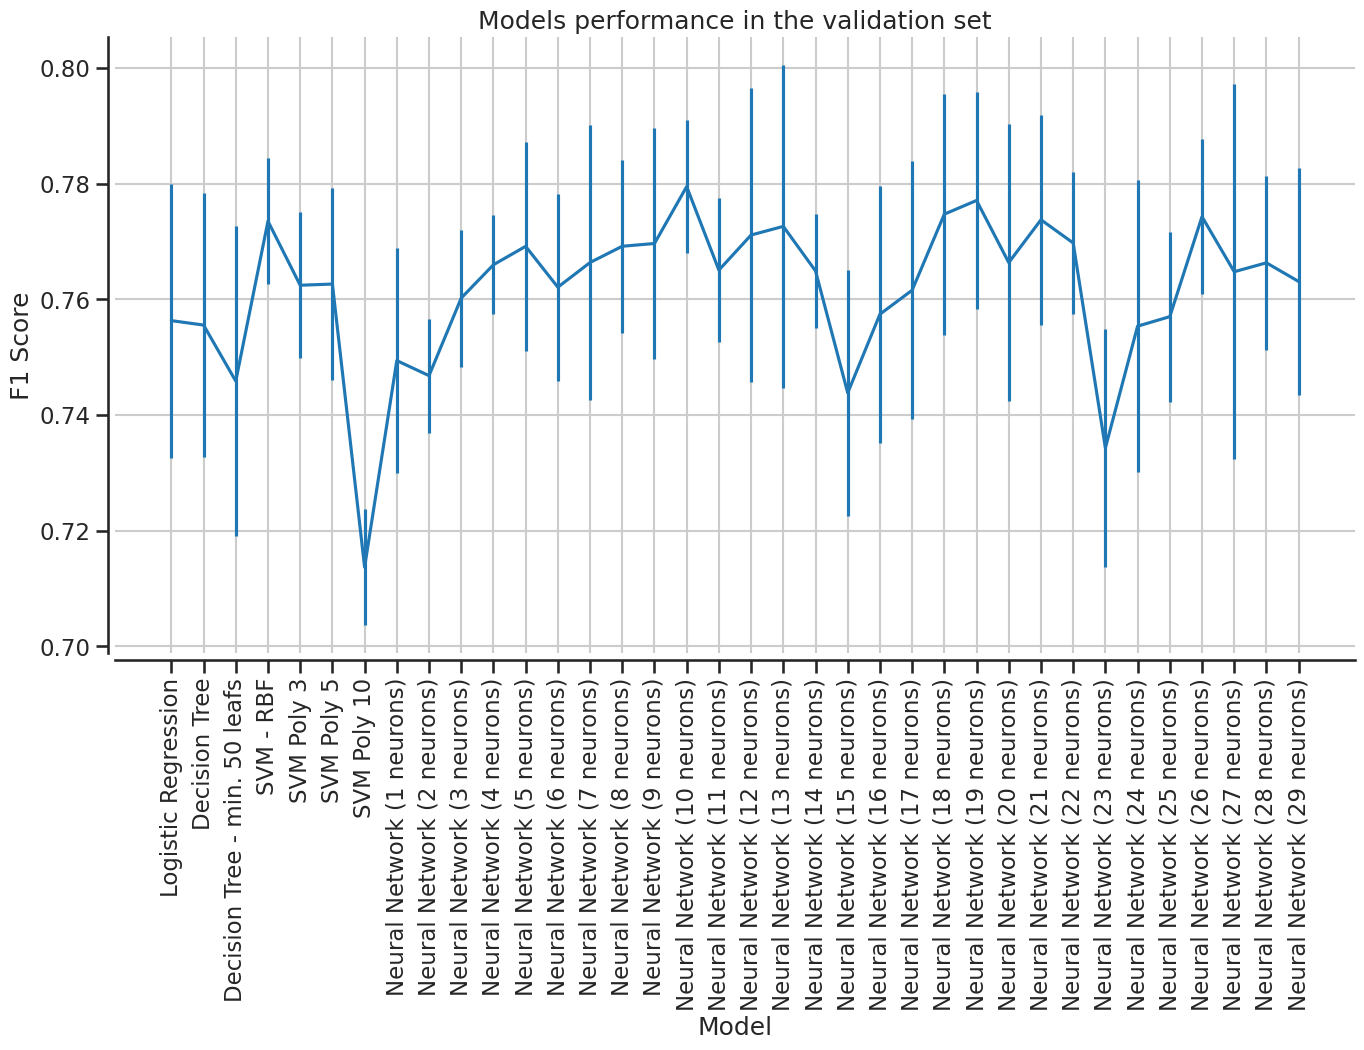

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(16,8))
plt.errorbar(range(results.shape[0]),
             results['Validation F1'],
             results['Validation F1 deviation'])
plt.grid(True)

sns.despine(offset=5)


plt.title("Models performance in the validation set")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(range(results.shape[0]),
           results.index,
           rotation=90);




In [ ]:
plt.xticklabels?

Object `plt.xticklabels` not found.
